In [1]:
import numpy as np
import cv2
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches

(22, 81, 3)


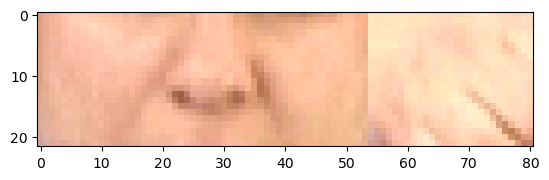

In [2]:
dir1 = 'cv23_lab2_material/part1 - GreekSignLanguage'
matRGB = scipy.io.loadmat(dir1 + '/skinSamplesRGB.mat')['skinSamplesRGB']
print(matRGB.shape)
plt.imshow(matRGB)

In [3]:
YCbCr=cv2.cvtColor(matRGB, cv2.COLOR_RGB2YCrCb) #.astype(float)
print(np.min(YCbCr), np.max(YCbCr))
#YCbCr = ((YCbCr - np.min(YCbCr))/np.max(YCbCr))
Cb = YCbCr[:,:,1]
Cr = YCbCr[:,:,2]
CbCr = YCbCr[:,:,1:]
mu = [np.mean(Cb), np.mean(Cr)]
print(mu)
Cbl = np.reshape(Cb, -1)
Crl = np.reshape(Cr, -1)
#CbCr = np.moveaxis(CbCr, 2 , 0)
Cov = np.cov(np.array([Cbl, Crl]))
print(Cov)
#print(np.cov())


95 242
[157.0460157126824, 103.27048260381594]
[[ 44.19103128 -11.9310385 ]
 [-11.9310385   11.19574811]]


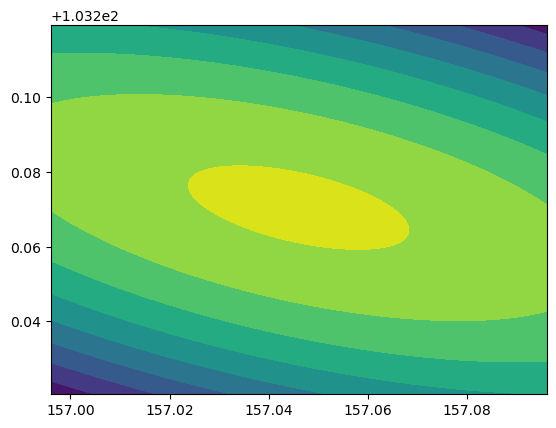

In [4]:
from scipy.stats import multivariate_normal
rv = multivariate_normal(mean=mu, cov=Cov, allow_singular=False)
x, y = np.mgrid[mu[0]-0.05:mu[0]+0.05:.001, mu[1]-0.05:mu[1]+0.05:0.001]
pos = np.dstack((x, y))
plt.contourf(x, y, rv.pdf(pos))

Loading image

(420, 350, 3)


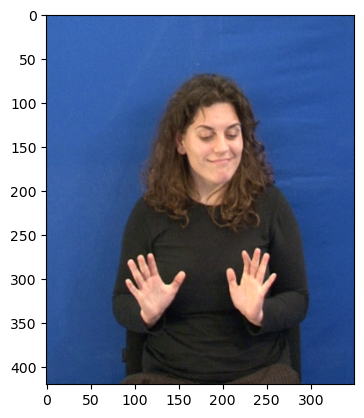

In [5]:
img = cv2.imread(dir1 + '/1.png', cv2.IMREAD_COLOR)
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Threshold probability of each pixel to picture skin

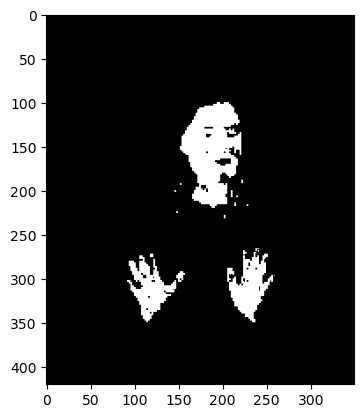

In [6]:
img = cv2.imread(dir1 + '/1.png', cv2.IMREAD_COLOR)
img_ = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
gaus_img = rv.pdf(img_[:,:,1:])
reg = (gaus_img - np.min(gaus_img)) / (np.max(gaus_img) - np.min(gaus_img))
plt.imshow((reg>0.03), cmap='gray' )
_, skin = cv2.threshold(reg, 0.03, 1, cv2.THRESH_BINARY)  


Opening and Closing of picture

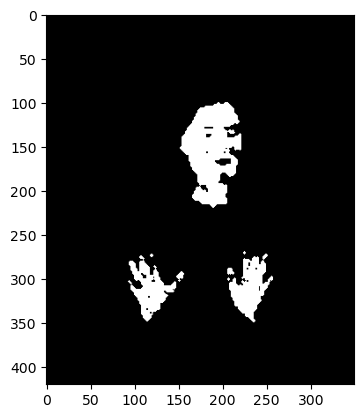

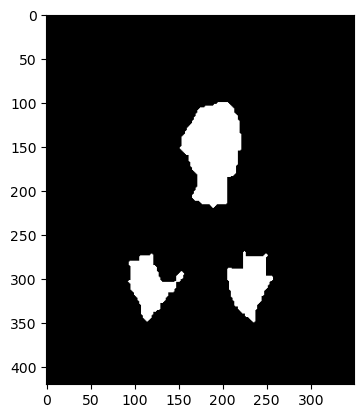

In [7]:
kernel_op = np.array([
                            [0,1,0],
                            [1,1,1],
                            [0,1,0]
                        ], dtype=np.uint8)
#kernel_op = np.ones((5, 5))
n=13
kernel_cl = [((n-i)//2)*[0]+ (i)*[1] + ((n-i)//2)*[0] for i in np.append(np.arange(1, n+1, 2), np.arange(n-2, 0, -2)) ]
kernel_cl = np.ones((13, 13))
kernel_cl = np.array(kernel_cl, dtype=np.uint8)


opening = cv2.morphologyEx(skin, cv2.MORPH_OPEN, kernel_op)
plt.imshow(opening, cmap='gray' )
plt.show()

closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE , kernel_cl)
plt.imshow(closing, cmap='gray' )

Marking different regions and plotting bounding boxes

[[152, 100, 69, 119], [206, 269, 51, 80], [93, 272, 63, 76]]


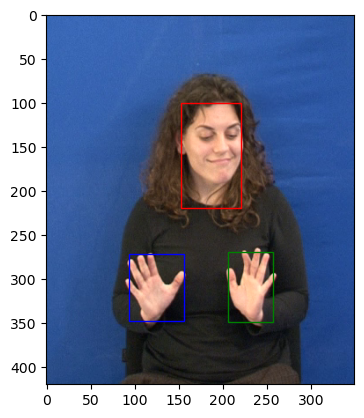

In [8]:
from scipy import ndimage

lbls, feats = scipy.ndimage.label(closing)
fig, ax = plt.subplots()

# Display the image
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
boxes = []
color = ['r', 'g', 'b']
for i in range(1, 4):
    f = np.transpose(np.where(lbls==i))   #returns the coordinates of each feature (hands, face)
    
    argminy = np.argmin(f[:,0])
    argmaxy = np.argmax(f[:,0])
    argminx = np.argmin(f[:,1])
    argmaxx = np.argmax(f[:,1])
    boxes.append([ f[argminx, 1], f[argminy,0], f[argmaxx,1]-f[argminx,1], f[argmaxy,0]-f[argminy,0] ])
    rect = patches.Rectangle((f[argminx, 1], f[argminy,0]), f[argmaxx,1]-f[argminx,1], f[argmaxy,0]-f[argminy,0], linewidth=1, edgecolor=color[i-1],
                              facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
print(boxes)

# Create a Rectangle patch

plt.show()

In [9]:
def fd(img, mu, cov):
    #conver to YCrCb color space
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    #create normal dist
    rv = multivariate_normal(mean=mu, cov=Cov, allow_singular=False)
    #apply it to image and normalize probability
    gaus_img = rv.pdf(img_[:,:,1:])
    reg = (gaus_img - np.min(gaus_img)) / (np.max(gaus_img) - np.min(gaus_img))
    #threshold to a value
    _, skin = cv2.threshold(reg, 0.03, 1, cv2.THRESH_BINARY)
    #apply filters
    kernel_op = np.array([
                            [0,1,0],
                            [1,1,1],
                            [0,1,0]
                        ], dtype=np.uint8)
    #kernel_op = np.ones((5, 5))
    n=11
    kernel_cl = [((n-i)//2)*[0]+ (i)*[1] + ((n-i)//2)*[0] for i in np.append(np.arange(1, n+1, 2), np.arange(n-2, 0, -2)) ]
    #kernel_cl = np.ones((13, 13))
    kernel_cl = np.array(kernel_cl, dtype=np.uint8)
    opening = cv2.morphologyEx(skin, cv2.MORPH_OPEN, kernel_op)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE , kernel_cl)

    lbls, feats = scipy.ndimage.label(closing)
    #print(feats)
    boxes = []
    for i in range(1, feats+1):
        f = np.transpose(np.where(lbls==i))
        aminy = np.argmin(f[:,0])
        amaxy = np.argmax(f[:,0])
        aminx = np.argmin(f[:,1])
        amaxx = np.argmax(f[:,1])
        boxes.append([ f[aminx, 1], f[aminy,0], f[amaxx,1]-f[aminx,1], f[amaxy,0]-f[aminy,0] ])

    while len(boxes) > 3:
         del boxes[np.argmin(np.array(boxes)[:, 2])]

    return boxes   

In [10]:
np.argmin(np.array(boxes)[:, 2])

1

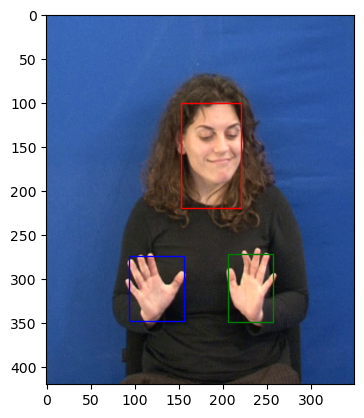

In [11]:
img = cv2.imread(dir1 + '/1.png', cv2.IMREAD_COLOR)
BoundindBox = fd(img, mu, Cov) 
fig, ax = plt.subplots()

# Display the image
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

c = 0
for i in BoundindBox:
    #print(i)
    rect = patches.Rectangle((i[0], i[1]), i[2], i[3], linewidth=1, edgecolor=color[c],
                          facecolor='none')
    # Add the patch to the Axes
    c +=1
    ax.add_patch(rect)
    
plt.show()

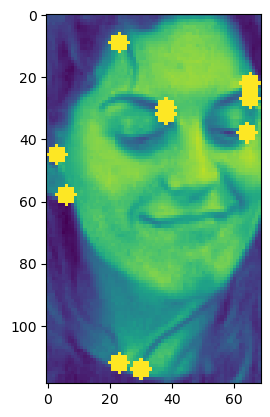

(<matplotlib.image.AxesImage at 0x1ef20bf6788>, None)

In [12]:
#lk(I1, I2, features, rho, epsilon, d x0, d y0)
img = cv2.imread(dir1 + '/1.png', cv2.IMREAD_COLOR) 
img_gray = cv2.imread(dir1 + '/1.png',  cv2.IMREAD_GRAYSCALE) 
img_gray2 = cv2.imread(dir1 + '/6.png',  cv2.IMREAD_GRAYSCALE) 
BoxingBox = fd(img, mu, Cov)
coords = BoxingBox[0]
img1 = img_gray[coords[1]:coords[1]+ coords[3], coords[0]: coords[0] + coords[2]]
img2 = img_gray2[coords[1]:coords[1]+ coords[3], coords[0]: coords[0] + coords[2]]

#plt.imshow(img1)
corners = cv2.goodFeaturesToTrack(img1,10,0.25,1)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv2.circle(img1,(x,y),3,255,-1)
plt.imshow(img1),plt.show()
#print(corners)

In [13]:
def gauss2D(sigma):
    n = int(2*np.ceil(3*sigma)+1)
    gauss1D = cv2.getGaussianKernel(n, sigma) # Column vector
    return gauss1D @ gauss1D.T # Symmetric gaussian kernel

In [14]:
#given I1, I2 are centered around face or hands
def lk(I1, I2, features, rho, epsilon, d_x0, d_y0):
    f = len(features)
    I1 = I1.astype(np.float64)/255
    I2 = I2.astype(np.float64)/255

    d_x = np.array(f*[d_x0])
    d_y = np.array(f*[d_y0])
    
    iterations = 100
 
    x = np.linspace(0,I1.shape[1]-1,I1.shape[1])
    y = np.linspace(0,I1.shape[0]-1,I1.shape[0]) 
    x0,y0 = np.meshgrid(x,y)
    #print(x0, y0)
    A = np.gradient(I1, 2)

    for i in range(iterations):
        for j in range(f):
            I1_d = scipy.ndimage.map_coordinates(I1,[np.ravel(y0 + d_y[j]),np.ravel(x0 + d_x[j])], order=1).reshape(I1.shape)
            A1 = scipy.ndimage.map_coordinates(A[0],[np.ravel(y0 + d_y[j]), np.ravel(x0 + d_x[j])], order=1).reshape(I1.shape)
            A2 = scipy.ndimage.map_coordinates(A[1],[np.ravel(y0 + d_y[j]), np.ravel(x0 + d_x[j])], order=1).reshape(I1.shape)

            E = I2 - I1_d

            u2_1 = cv2.filter2D(A1*E, -1, gauss2D(rho)) 
            u2_2 = cv2.filter2D(A2*E, -1, gauss2D(rho))
            A1A2 = cv2.filter2D(A1*A2, -1, gauss2D(rho))
            A1_2 = cv2.filter2D(A1**2, -1, gauss2D(rho)) + epsilon
            A2_2 = cv2.filter2D(A2**2, -1, gauss2D(rho)) + epsilon
            det = A1_2*A2_2 - A1A2**2

            ux = (A2_2*u2_1 + (-A1A2*u2_2))/det 
            uy = (-A1A2*u2_1 + A1_2*u2_2)/det

            #print(ux.shape)
            d_x[j] = d_x[j] + ux[int(features[j][0][1]), int(features[j][0][0])]
            d_y[j] = d_y[j] + uy[int(features[j][0][1]), int(features[j][0][0])]
            #print(d_y, d_x)
            
    return d_y, d_x 

#### Experimenting with artificial image shifting to test lk 

#### img1 (face) is shifted 2 pixels down and optical flow vectors are plotted

14


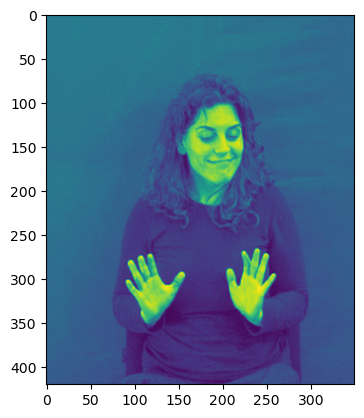

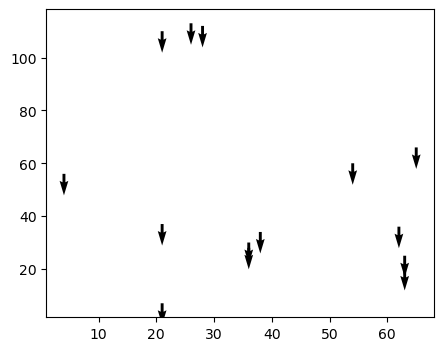

In [32]:
x = 154 
y= 102 
width = 67 
height = 115 

img_gray1 = cv2.imread(dir1 + '/' + "1" + '.png',  cv2.IMREAD_GRAYSCALE) 
img_gray2 = cv2.imread(dir1 + '/' + "2" + '.png',  cv2.IMREAD_GRAYSCALE) 
#img_gray1 = cv2.pyrDown(img_gray1)
img1 = img_gray1[y+1:y+1 + height, x:x + width]
img2 = img_gray1[y:y  + height, x:x + width]

# plt.imshow(img1)
# plt.show()
# plt.imshow(img2)

fig, ax = plt.subplots()
ax.imshow(img_gray2)

feats = cv2.goodFeaturesToTrack(img2, 20, 0.2, 2)

print(len(feats))
d_x, d_y = lk(img1, img2, feats, 2.5, 0.1, 0.1, 0)
#d_x, d_y = multiscale_lk(img1, img2, 2.5, 0.1, 3)
# #quiver
fig, ax = plt.subplots(figsize = (5, 4))
for f in range(len(feats)):
    x_pos = feats[f][0][0]
    y_pos = feats[f][0][1]
    ax.quiver(x_pos, y_pos, d_x[f], d_y[f])

#Show plot
plt.show()

#### img1 (face) is shifted 2 pixels left and optical flow vectors are plotted

14


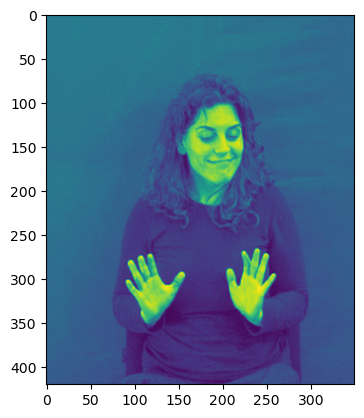

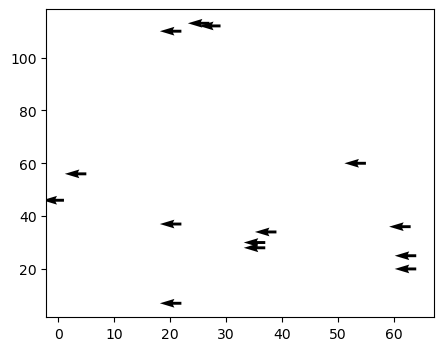

In [31]:
x = 154
y= 102
width = 67
height = 115

img_gray1 = cv2.imread(dir1 + '/' + "1" + '.png',  cv2.IMREAD_GRAYSCALE) 
img_gray2 = cv2.imread(dir1 + '/' + "2" + '.png',  cv2.IMREAD_GRAYSCALE) 
img1 = img_gray1[y:y + height, x:x + width]
img2 = img_gray1[y:y  + height, x-1:x-1 + width]

# plt.imshow(img1)
# plt.show()
# plt.imshow(img2)

fig, ax = plt.subplots()
ax.imshow(img_gray2)

feats = cv2.goodFeaturesToTrack(img2, 20, 0.2, 2)

print(len(feats))
d_x, d_y = lk(img1, img2, feats, 2.5, 0.1, 0, 0.1)
#d_x, d_y = multiscale_lk(img1, img2, 2.5, 0.1, 3)
# #quiver
fig, ax = plt.subplots(figsize = (5, 4))
for f in range(len(feats)):
    x_pos = feats[f][0][0]
    y_pos = feats[f][0][1]
    ax.quiver(x_pos, y_pos, d_x[f], d_y[f])
#Show plot
plt.savefig("geeks.png")
plt.show()

In [15]:
def displ(d_x, d_y):
    th = 0.05
    mean_flow_x = 0
    mean_flow_y = 0
    for i in range(len(d_x)):
        if (np.sqrt(d_x[i]**2 + d_y[i]**2) > th):
            mean_flow_x += d_x[i]
            mean_flow_y += d_y[i]
    return [int(mean_flow_x/len(d_x)), int(mean_flow_y/len(d_y))]

#### Left Hand Tracking One-Scale LK

In [ ]:
x = 93
y= 272 
width = 56
height = 83 
for i in range(68):
    imgp = cv2.imread(dir1 + '/' + str(i+2) + '.png')
    img_gray1 = cv2.imread(dir1 + '/' + str(i+1) + '.png',  cv2.IMREAD_GRAYSCALE) 
    img_gray2 = cv2.imread(dir1 + '/' + str(i+2) + '.png',  cv2.IMREAD_GRAYSCALE) 
    #img_smoothed1 = cv2.filter2D(img_gray1, -1, gauss2D(1.5))
    #img_smoothed2 = cv2.filter2D(img_gray2, -1, gauss2D(1.5))
    img1 = img_gray1[y:y + height, x:x + width]
    img2 = img_gray2[y:y + height, x:x + width]

    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(imgp, cv2.COLOR_BGR2RGB))
    
    feats = cv2.goodFeaturesToTrack(img2, 20, 0.01, 5)
    d_x, d_y = lk(img1, img2, feats, 5, 0.1, 0.1, 0.1)
    
    coords = displ(d_x, d_y)
    #print(d_x, d_y)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    print(coords)
    x = x - coords[0]
    y = y - coords[1]
    print(x, y)
    plt.savefig("one_scale/left_hand_one_scale/im_" + str(i) + ".png")
    plt.show()
    


In [ ]:
for i in range(68):
    img_gray1 = cv2.imread(dir1 + '/' + str(i+1) + '.png',  cv2.IMREAD_GRAYSCALE) 
    img_gray2 = cv2.imread(dir1 + '/' + str(i+2) + '.png',  cv2.IMREAD_GRAYSCALE) 
    #img_smoothed1 = cv2.filter2D(img_gray1, -1, gauss2D(1.5))
    #img_smoothed2 = cv2.filter2D(img_gray2, -1, gauss2D(1.5))
    img1 = img_gray1[y:y + height, x:x + width]
    img2 = img_gray2[y:y + height, x:x + width]

    #fig, ax = plt.subplots()
    #ax.imshow(img_gray2)
    
    feats = cv2.goodFeaturesToTrack(img2, 20, 0.01, 5)
    d_x, d_y = lk(img1, img2, feats, 5, 0.1, 0.1, 0.1)
    
    coords = displ(d_x, d_y)
    print(coords)
    x = x - coords[0]
    y = y - coords[1]
    print(x, y)
    
    #quiver
    fig, ax = plt.subplots(figsize = (5, 4))
    for f in range(len(feats)):
        x_pos = feats[f][0][0]
        y_pos = feats[f][0][1]
        ax.quiver(x_pos, y_pos, -d_x[f], -d_y[f])
    plt.savefig("left_hand_one_scale_of_vectors/im_" + str(i) + ".png")
    plt.show()

#### Right Hand Tracking One-Scale LK

In [ ]:
x = 201
y = 270
width = 56
height = 83

for i in range(68):
    imgp = cv2.imread(dir1 + '/' + str(i+2) + '.png')
    img_gray1 = cv2.imread(dir1 + '/' + str(i+1) + '.png',  cv2.IMREAD_GRAYSCALE) 
    img_gray2 = cv2.imread(dir1 + '/' + str(i+2) + '.png',  cv2.IMREAD_GRAYSCALE) 
    #img_smoothed1 = cv2.filter2D(img_gray1, -1, gauss2D(1.5))
    #img_smoothed2 = cv2.filter2D(img_gray2, -1, gauss2D(1.5))
    img1 = img_gray1[y:y + height, x:x + width]
    img2 = img_gray2[y:y + height, x:x + width]

    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(imgp, cv2.COLOR_BGR2RGB))
    
    feats = cv2.goodFeaturesToTrack(img2, 20, 0.01, 5)
    d_x, d_y = lk(img1, img2, feats, 5, 0.1, 0.1, 0.1)
    
    coords = displ(d_x, d_y)
    #print(d_x, d_y)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    print(coords)
    x = x - coords[0]
    y = y - coords[1]
    print(x, y)
    plt.savefig("one_scale/right_hand_one_scale/im_" + str(i) + ".png")
    plt.show()

In [ ]:
x = 201
y = 270
width = 56
height = 83
for i in range(68):
    img_gray1 = cv2.imread(dir1 + '/' + str(i+1) + '.png',  cv2.IMREAD_GRAYSCALE) 
    img_gray2 = cv2.imread(dir1 + '/' + str(i+2) + '.png',  cv2.IMREAD_GRAYSCALE) 
    #img_smoothed1 = cv2.filter2D(img_gray1, -1, gauss2D(1.5))
    #img_smoothed2 = cv2.filter2D(img_gray2, -1, gauss2D(1.5))
    img1 = img_gray1[y:y + height, x:x + width]
    img2 = img_gray2[y:y + height, x:x + width]

    #fig, ax = plt.subplots()
    #ax.imshow(img_gray2)
    
    feats = cv2.goodFeaturesToTrack(img2, 20, 0.01, 5)
    d_x, d_y = lk(img1, img2, feats, 5, 0.1, 0.1, 0.1)
    
    coords = displ(d_x, d_y)
    print(coords)
    x = x - coords[0]
    y = y - coords[1]
    print(x, y)
    
    #quiver
    fig, ax = plt.subplots(figsize = (5, 4))
    for f in range(len(feats)):
        x_pos = feats[f][0][0]
        y_pos = feats[f][0][1]
        ax.quiver(x_pos, y_pos, -d_x[f], -d_y[f])
    plt.savefig("right_hand_one_scale_of_vectors/im_" + str(i) + ".png")
    plt.show()

#### Face Tracking One-Scale LK

In [ ]:
x = 154
y= 102
width = 67
height = 115

for i in range(68):
    imgp = cv2.imread(dir1 + '/' + str(i+2) + '.png')
    img_gray1 = cv2.imread(dir1 + '/' + str(i+1) + '.png',  cv2.IMREAD_GRAYSCALE) 
    img_gray2 = cv2.imread(dir1 + '/' + str(i+2) + '.png',  cv2.IMREAD_GRAYSCALE) 
    #img_smoothed1 = cv2.filter2D(img_gray1, -1, gauss2D(1.5))
    #img_smoothed2 = cv2.filter2D(img_gray2, -1, gauss2D(1.5))
    img1 = img_gray1[y:y + height, x:x + width]
    img2 = img_gray2[y:y + height, x:x + width]

    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(imgp, cv2.COLOR_BGR2RGB))
    
    feats = cv2.goodFeaturesToTrack(img2, 20, 0.2, 2)
    d_x, d_y = lk(img1, img2, feats, 2.5, 0.1, 0.1, 0.1)
    
    coords = displ(d_x, d_y)
    #print(d_x, d_y)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    print(coords)
    x = x - coords[0]
    y = y - coords[1]
    print(x, y)
    plt.savefig("one_scale/face_one_scale/im_" + str(i) + ".png")
    plt.show()

In [ ]:
x = 154
y= 102
width = 67
height = 115
for i in range(68):
    img_gray1 = cv2.imread(dir1 + '/' + str(i+1) + '.png',  cv2.IMREAD_GRAYSCALE) 
    img_gray2 = cv2.imread(dir1 + '/' + str(i+2) + '.png',  cv2.IMREAD_GRAYSCALE) 
    #img_smoothed1 = cv2.filter2D(img_gray1, -1, gauss2D(1.5))
    #img_smoothed2 = cv2.filter2D(img_gray2, -1, gauss2D(1.5))
    img1 = img_gray1[y:y + height, x:x + width]
    img2 = img_gray2[y:y + height, x:x + width]

    #fig, ax = plt.subplots()
    #ax.imshow(img_gray2)
    
    feats = cv2.goodFeaturesToTrack(img2, 20, 0.01, 5)
    d_x, d_y = lk(img1, img2, feats, 5, 0.1, 0.1, 0.1)
    
    coords = displ(d_x, d_y)
    print(coords)
    x = x - coords[0]
    y = y - coords[1]
    print(x, y)
    
    #quiver
    fig, ax = plt.subplots(figsize = (5, 4))
    for f in range(len(feats)):
        x_pos = feats[f][0][0]
        y_pos = feats[f][0][1]
        ax.quiver(x_pos, y_pos, -d_x[f], -d_y[f])
    plt.savefig("face_one_scale_of_vectors/im_" + str(i) + ".png")
    plt.show()

#### Multi-Scale Lucas-Kanade

In [30]:
def multiscale_lk(I1, I2, rho, epsilon, no_of_scales):
    for i in range(no_of_scales):
        I1 = cv2.pyrDown(I1)
        I2 = cv2.pyrDown(I2)
    
    d_x0 = 0.1
    d_y0 = 0.1
    for i in range(no_of_scales):
        feats = cv2.goodFeaturesToTrack(I2, 20, 0.2, 1)
        if feats is None:
            feats = fix_feats(20, I2.shape[1], I2.shape[0])
            print("aaa")
            d_x0 = 5*d_x0
            d_y0 = 5*d_y0
            #feats = find_k_max_indices(I2, 15)
        print(len(feats))
        d_x, d_y = lk(I1, I2, feats, rho, epsilon, 2*d_x0, 2*d_y0)
        d_x0, d_y0 = displ(d_x, d_y)
        I1 = cv2.pyrUp(I1)
        I2 = cv2.pyrUp(I2)
    if(no_of_scales == 0):
        feats = cv2.goodFeaturesToTrack(I2, 20, 0.2, 1)
        d_x, d_y = lk(I1, I2, feats, rho, epsilon, d_x0, d_y0)
    return d_x, d_y

In [17]:
import numpy as np

def find_k_max_indices(arr, k):
    flattened_indices = np.argpartition(arr.flatten(), -k)[-k:]
    indices_2d = np.unravel_index(flattened_indices, arr.shape)
    result = [[[indices_2d[1][i], indices_2d[0][i]]] for i in range(k)] 
    return result

def fix_feats(size, l1, l2):
    #print("aa")
    y = []
    #y.extend([[1,0]], [[1,1]], [[l1-]])
    for i in range(size):
#         a = np.argmax(img)
#         print(a)
#         a = np.unravel_index(a, (l2,l1))
#         img[a] = 0
        k = np.random.randint(l1)
        l = np.random.randint(l2)
        y.append([[k, l]])
    return y

#### Left Hand Tracking Multi-Scale LK

In [ ]:
x = 93
y= 272 
width = 56 
height = 83 

for i in range(68):
    imgp = cv2.imread(dir1 + '/' + str(i+2) + '.png')
    img_gray1 = cv2.imread(dir1 + '/' + str(i+1) + '.png',  cv2.IMREAD_GRAYSCALE) 
    img_gray2 = cv2.imread(dir1 + '/' + str(i+2) + '.png',  cv2.IMREAD_GRAYSCALE) 

    img1 = img_gray1[y:y + height, x:x + width]
    img2 = img_gray2[y:y + height, x:x + width]
    
    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(imgp, cv2.COLOR_BGR2RGB))

    #feats = cv2.goodFeaturesToTrack(img2, 20, 0.3, 2)
    d_x, d_y = multiscale_lk(img1, img2, 2.5, 0.1, 3)

    coords = displ(d_x, d_y)
    #print(d_x, d_y)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    print(coords)
    x = x - coords[0] 
    y = y - coords[1]
    print(x, y)
    plt.savefig("multi_scale/left_hand_multi_scale/im_" + str(i) + ".png")
    plt.show()
    

#### RIght Hand Tracking Multi-Scale LK

In [ ]:
x = 201
y= 270
width = 56
height = 83

for i in range(68):
    imgp = cv2.imread(dir1 + '/' + str(i+2) + '.png')
    img_gray1 = cv2.imread(dir1 + '/' + str(i+1) + '.png',  cv2.IMREAD_GRAYSCALE) 
    img_gray2 = cv2.imread(dir1 + '/' + str(i+2) + '.png',  cv2.IMREAD_GRAYSCALE) 
    img1 = img_gray1[y:y + height, x:x + width]
    img2 = img_gray2[y:y + height, x:x + width]
    
    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(imgp, cv2.COLOR_BGR2RGB))

    #feats = cv2.goodFeaturesToTrack(img2, 20, 0.3, 2)
    d_x, d_y = multiscale_lk(img1, img2, 5, 0.1, 1)

    coords = displ(d_x, d_y)
    #print(d_x, d_y)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    print(coords)
    x = x - coords[0]
    y = y - coords[1]
    print(x, y)
    plt.savefig("multi_scale/right_hand_multi_scale/im_" + str(i) + ".png")
    plt.show()

#### Face Tracking Multi-Scale LK

In [ ]:
x = 154
y= 102
width = 67
height = 115

for i in range(60):
    imgp = cv2.imread(dir1 + '/' + str(i+2) + '.png')
    img_gray1 = cv2.imread(dir1 + '/' + str(i+1) + '.png',  cv2.IMREAD_GRAYSCALE) 
    img_gray2 = cv2.imread(dir1 + '/' + str(i+2) + '.png',  cv2.IMREAD_GRAYSCALE) 
    img1 = img_gray1[y:y + height, x:x + width]
    img2 = img_gray2[y:y + height, x:x + width]
    
    fig, ax = plt.subplots()
    ax.imshow(cv2.cvtColor(imgp, cv2.COLOR_BGR2RGB))

    #feats = cv2.goodFeaturesToTrack(img2, 20, 0.3, 2)
    d_x, d_y = multiscale_lk(img1, img2, 2.5, 0.1, 2)

    coords = displ(d_x, d_y)
    #print(d_x, d_y)
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    print(coords)
    x = x - coords[0]
    y = y - coords[1]
    print(x, y)
    plt.savefig("multi_scale/face_multi_scale/im_" + str(i) + ".png")
    plt.show()

In [63]:
def softmax(vector):
    e = np.exp(vector)
    return e / e.sum()

a = np.array([-4.38, 0, 0, 0, 7.2, 1.06, 0, 0, -0.04, -3.45, 2.74, 0, -14.89, -2.65, -13.7, 3.62]).reshape(4,4)

b = softmax(a)
b
V = np.array([-2.5, -7.5, 0.25, 0, -2, -5.25, -0.75, -1.5]).reshape(4,2)
out = b @ V
b

array([[8.93253686e-06, 7.13156176e-04, 7.13156176e-04, 7.13156176e-04],
       [9.55223322e-01, 2.05843330e-03, 7.13156176e-04, 7.13156176e-04],
       [6.85192922e-04, 2.26395966e-05, 1.10446391e-02, 7.13156176e-04],
       [2.43522903e-10, 5.03853489e-05, 8.00479558e-10, 2.66275171e-02]])